# How to Sample

This notebook is my own summarizing parts of this video from PyData London 2017: 

SaaaS - Sampling as an Algorithm Service, given by Vincent D. Warmerdam

link: https://www.youtube.com/watch?v=8g6oF8vUqTU

1. Have data (D) and parameters (theta) we want to estimate

2. Sample around the parameter space using a markov chain
  * Init the parameters randomly
  * Choose another set of random parameters in the same area
  * Calculate the likelihood of that data coming from those parameters
  * If the next set of parameters has a higher likelihood always take that step
  * If the parameters have a lower likelihood do a coin flip to see if you take the step or not. The probability of making the step depends of the ratio of likelihood, ie if the new step is comparitively much less likely then it will also be less likely to take the step
    
3. Repeat a lot of times

What this does is, after a burn in period where the markov chain starts in an area of low likelihood, the chain will sample from areas with high likelihood proportionally more than lower likelihood areas. So, we can take all the accepted samples and plot them on a histogram and see which values have been sampled the most. This gives us the values of our distribution in question.


In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Lets code up an example of finding parameters using sampling!

Can we recover the parameters of the distribution we generated our fake data with?

In [2]:
a, b = np.random.randint(-10, 10, (2, 10))

In [3]:
#Draw 100 samples from a normal distribution with a mean of 1 and standard deviation of 0.5 
#These data points will function as our observations that we will try to recover the parameters for. 
#scale = standard deviation (sigma) and loc = mean (mu)
nums = np.random.normal(loc=1, scale=0.5, size=100)


#All of our mus(mean) will be appended to this list
mu = [0]

#Same but for our sigma(standard deviation) values
sigma = [3]

#stepsize controls how big of a step the chain will take to a new sample
stepsize= 0.1

#helper function to calculate the likelihood that the data came from the distribution
def calculate_likelihood(data, mu, sigma):
    #Take in the mean and standard deviation values then calculate for each data point in data
    #the pobability of that point being drawn from this distribution
    probability_values = stats.norm.pdf(data, loc=mu, scale=sigma)
    
    return np.prod(probability_values) #multiply all probabilities together to get one value


In [4]:
steps = 100000

for i in range(steps):
    #Pick new mu and sigma values by picking a random value a stepsize away from the previous value
    new_mu = mu[-1] + np.random.normal(0, stepsize, 1)[0]
    new_sigma = sigma[-1] + np.random.normal(0, stepsize, 1)[0]
    
    #Calculate the likelihood that our data was generated by the current parameters and new parameters
    current_likelihood = calculate_likelihood(nums, mu[-1], sigma[-1])
    new_likelihood = calculate_likelihood(nums, new_mu, new_sigma)
    
    #Pick a random decimal from 0 to 1 and if it is less than the ratio of the new/current likelihood take the
    #step and append the new mu and sigma values, otherwise append the current mu and sigma again
    if np.random.random() < (new_likelihood / current_likelihood):
        mu.append(new_mu)
        sigma.append(new_sigma)
    else:
        mu.append(mu[-1])
        sigma.append(sigma[-1])
        

## Plot Traces of Mu and Sigma and Histograms of Values

You can see the first part of the trace looks very different from the rest. This is becasue when we randomly selected the initial parameters its usually the case that it starts in a low likelihood area. Then once the markov chain finds areas of high likelihood it will provide an unbiased sampling of the distribution.

Generally, this part of the trace is not used as it is not an accurate representation of the distribution. To overcome this problem you can specify a burn in time which is how many steps you will throw out before you will get unbiased samples from the distribution. 

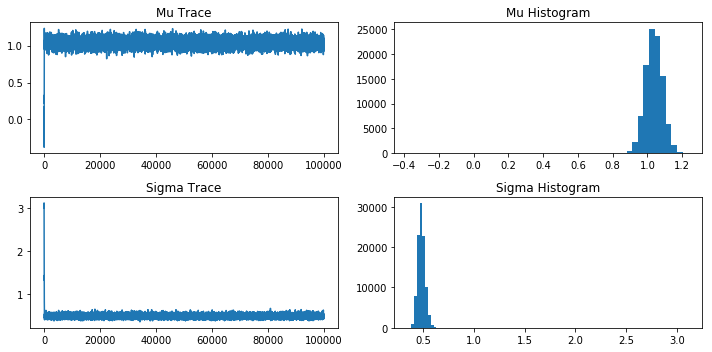

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

axes[0][0].plot(mu)
axes[0][0].set_title('Mu Trace')
axes[0][1].hist(mu, bins=50)
axes[0][1].set_title('Mu Histogram')

axes[1][0].plot(sigma)
axes[1][0].set_title('Sigma Trace')
axes[1][1].hist(sigma, bins=100)
axes[1][1].set_title('Sigma Histogram')
plt.tight_layout();

## Feel the Burn

Here we add in the burn in time which throws out the first part of the trace before it reaches convergence

As you can see the histograms are much clearer about the proper distributions

You can adjust the burn in time to include more samples depending on how long it takes to converge

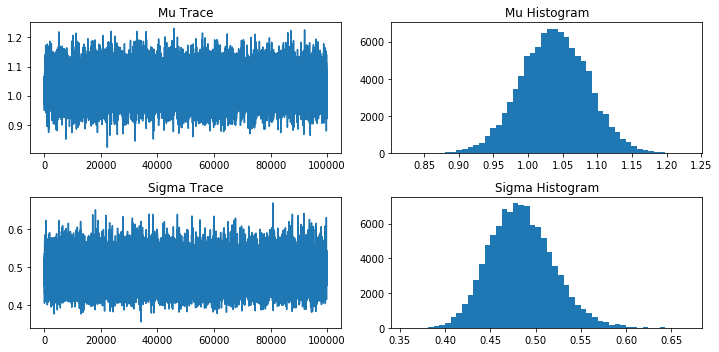

In [5]:
burn = 100

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

axes[0][0].plot(mu[burn:])
axes[0][0].set_title('Mu Trace')
axes[0][1].hist(mu[burn:], bins=50)
axes[0][1].set_title('Mu Histogram')

axes[1][0].plot(sigma[burn:])
axes[1][0].set_title('Sigma Trace')
axes[1][1].hist(sigma[burn:], bins=50)
axes[1][1].set_title('Sigma Histogram')
plt.tight_layout();

## Fun with StepSize: Why size matters

How does step size effect our sampling?

Lets just turn our for loop into a function so we can easily change the stepsize

In [9]:
def sample(nums, mu, sigma, stepsize, samples):
    mu = [mu]
    sigma = [sigma]
    while len(mu) < samples:
        new_mu = mu[-1] + np.random.normal(0, stepsize, 1)[0]
        new_sigma = sigma[-1] + np.random.normal(0, stepsize, 1)[0]

        current_likelihood = calculate_likelihood(nums, mu[-1], sigma[-1])
        new_likelihood = calculate_likelihood(nums, new_mu, new_sigma)

        if np.random.random() < (new_likelihood / current_likelihood):
            mu.append(new_mu)
            sigma.append(new_sigma)
        else:
            mu.append(mu[-1])
            sigma.append(sigma[-1])
    return mu, sigma

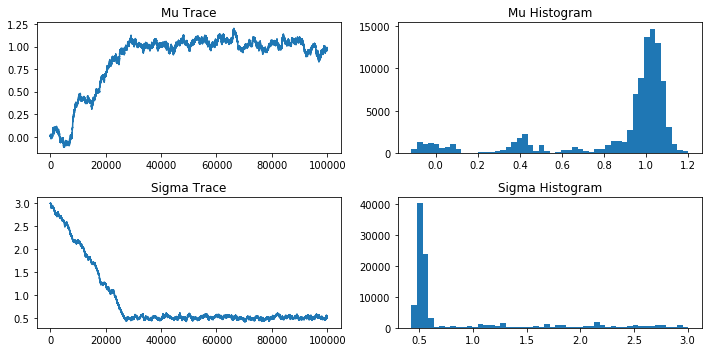

In [12]:
#Lets use a smaller step size of .001
mu_small_step, sigma_small_step = sample(nums, 0, 3, .002, 100000)

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

axes[0][0].plot(mu_small_step)
axes[0][0].set_title('Mu Trace')
axes[0][1].hist(mu_small_step, bins=50)
axes[0][1].set_title('Mu Histogram')

axes[1][0].plot(sigma_small_step)
axes[1][0].set_title('Sigma Trace')
axes[1][1].hist(sigma_small_step, bins=50)
axes[1][1].set_title('Sigma Histogram')
plt.tight_layout();

What happened here?

This doesn't look right at all. The traces haven't converged at all and the histograms are all over the place.

When we choose a very small step size the chain doesn't have enough time to step all the way over to the areas of high likelihood. Since we initiated our values for Mu at 0 we remain around the 0 because with each step we can't go very far. This means that the true value of 0.5 is not even considered. The same story for sigma. We initiated our value at 3 and it can't leave this area because our step size is so small. It never reaches the area of high likelihood around 1 and remains unconveraged.

It is possible that with enough steps we will eventually reach the areas of high likelihood but it could take a very very long time.

Lets try a much bigger step size and see what happens

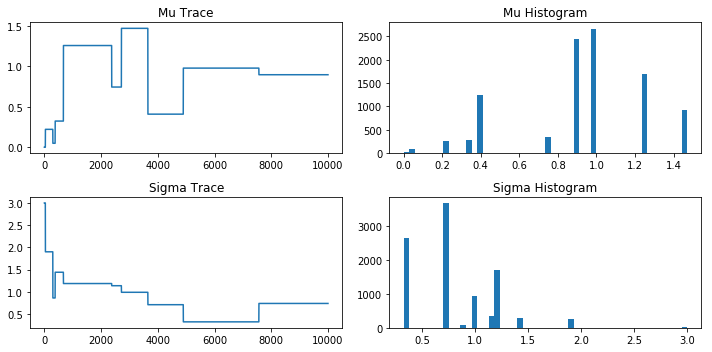

In [18]:
#Lets use a smaller step size of .001
mu_big_step, sigma_big_step = sample(nums, 0, 3, 10, 10000)

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

axes[0][0].plot(mu_big_step)
axes[0][0].set_title('Mu Trace')
axes[0][1].hist(mu_big_step, bins=50)
axes[0][1].set_title('Mu Histogram')

axes[1][0].plot(sigma_big_step)
axes[1][0].set_title('Sigma Trace')
axes[1][1].hist(sigma_big_step, bins=50)
axes[1][1].set_title('Sigma Histogram')
plt.tight_layout();

As we can see here there are much fewer new samples accepted. With a large step size we quickly move from the initialized values to the area of high likelihood but once there we are simply stuck rejecting almost every step because we can propose such a wide range of values and most every other step will be worse compared with the area of high likelihood. 

We get a quick approximation of the maximum value but when we look at the histogram we get very little information about the surrounding likelihood density.

Smaller steps would give us the fine grain detail we are after